<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Consensus-structure-from-RNAalifold" data-toc-modified-id="Consensus-structure-from-RNAalifold-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Consensus structure from RNAalifold</a></span><ul class="toc-item"><li><span><a href="#Hard-constraints" data-toc-modified-id="Hard-constraints-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Hard constraints</a></span></li><li><span><a href="#Soft-constraints-(pseudo-energies)-with-softconsensus" data-toc-modified-id="Soft-constraints-(pseudo-energies)-with-softconsensus-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Soft constraints (pseudo-energies) with softconsensus</a></span></li><li><span><a href="#evaluate-predictions" data-toc-modified-id="evaluate-predictions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>evaluate predictions</a></span></li></ul></li></ul></div>

In this notebook, we aim to show how to use [softconsensus](#Soft-constraints-(pseudo-energies)-with-softconsensus) to help predicting secondary structure with phylogenetic information and to explain the motivation behind it.
We use 5S rRNA family (Rfam ID: [RF00001](https://rfam.org/family/RF00001)) as the running exaple.
Several sequences are removed from the alignment such that any two sequences in the alignment have less than 80% similarity.
The first sequence in the alignment is chosen to be the focal sequence, the one to predict.

In [1]:
import RNA
import numpy as np
from IPython.display import SVG, display, HTML

# Import functions from RNAsoftconsensus
from softconsensus import Alignment, read_alignment
import MCC_stats as MCC

In [2]:
alignment_file = "test/5S_rRNA_test_alignment.fa"
reference_file = "test/test_reference.fa"

In [3]:
alignment = [w for w in read_alignment(alignment_file, 'fasta')]
sequences = [w.replace('-', '') for w in alignment]
focal_seq = sequences[0]
focal_seq_aligned = alignment[0]

__Reference structure from RNAcentral__

# Reference structure:
UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
((((((((((.....((((((((....(((((((.............))))..)))...)))))).)).((.((....((((((((...))))))))....)).))...)))))))))).


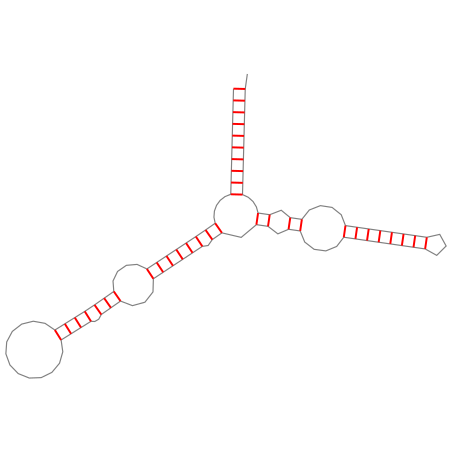

In [4]:
with open(reference_file) as f:
    next(f)
    next(f)
    reference_ss = next(f).strip()
    
def plot_structure(ss, path, show_ref=True, label=''):
    print(focal_seq)
    print(ss)
    RNA.svg_rna_plot(' '*len(ss), ss, path)
    if show_ref:
        context = "<table><tr><td><img src='{}'></td><td><img src='{}'></td></tr><tr><td style='text-align: center;'>Reference</td><td style='text-align: center;'>{}</td></tr></table>"
        display(HTML(context.format('test/images/reference.svg', path, label))) 
    else:
        display(SVG(path))
        
print("# Reference structure:")
plot_structure(reference_ss, 'test/images/reference.svg', show_ref=False)

__MFE structure without constraint__

As shown below, the predicted MFE structure using _RNAfold_ is quite distinct to the reference one.

In [5]:
mfe_ss, _ = RNA.fold(focal_seq)
plot_structure(mfe_ss, 'test/images/seq.svg', label='Unconstrained MFE')

UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
((((((((((((((...)))).(((...))).((((((((((...((.((...(((..((...))..)))...)))).))))))))))..(((.(((....))))))..)))))))))).


,
Reference,Unconstrained MFE


# Consensus structure from RNAalifold

One way to improve the prediction is integrating the phylogenetic information from the alignment.
First, we compute the consensus structure and the base pair probability matrix using _RNAalifold_.
Then, adding such information in the prediction using hard or soft constraints.

In [6]:
fc_ali = RNA.fold_compound(alignment)

css, cen = fc_ali.mfe()
print(css, cen)

fc_ali.exp_params_rescale(cen)
fc_ali.pf()
bpp = np.array(fc_ali.bpp())

..((((((((.(....(((((.(.((.........((((.............))).).........))))))..)).(..((.((........(((((..((....)).)))))......))..)).)..).))))))))... -40.65581512451172


## Hard constraints
__"Cleaning up" the consensus structure - removing non-canonical base pairs, gap positions__
The `refold` function allow to extract the projection of the _RNAalifold_ consensus structure for each sequence in the alignment and clear the structure by removing base pairs that are mapped to gaps in the alignment and base pairs that do not satisfy the minimum loop length condition (default=3). A threshold can be given to keep only base pairs with probability > threshold. 

In [7]:
def refold(sequence, css, bpp, threshold=None, turn=3):
    pair = ['AU', 'UA', 'GC', 'CG', 'GU', 'UG']
    cons_ss_cleaned = []
    
    pt = RNA.ptable_pk(css)
    seq = 'x'+sequence
    if threshold is not None:
        cons = list('x' + '.'*len(css))
        for p in pt:
            if p>pt[p]:
                continue
            if bpp[p][pt[p]] >= threshold:
                cons[p] = '('
                cons[pt[p]] = ')'
    else:
        cons = ['x']+list(css) # consensus structure by alifold
        
    # remove non-compatible pairs as well as pairs to a gap position in the sequence
    for p in range(1, len(seq)):
        c = seq[p]
        if c == '-':
            cons[p] = 'x'
            if pt[p]>0 and cons[pt[p]] != 'x':
                cons[pt[p]] = '.'
        elif pt[p] > p and c+seq[pt[p]] not in pair:
            cons[p] = cons[pt[p]] = '.'
    
    # remove all hairpins with length < turn
    s_cons = ''.join(cons).replace('x', '')
    pt = RNA.ptable_pk(s_cons)
    s_cons = list('x'+s_cons)
    for p in range(1, len(pt)):
        if p > pt[p]:
            continue
        if pt[p] - p-1 < turn:
            s_cons[p] =  s_cons[pt[p]] = '.'

    ss = ''.join(s_cons).replace('x', '')
    
    return ss

__Consensus structure projection__ captures the main structure shape, but contains unwanted unpaired regions

In [8]:
threshold = 0.95
turn = 3

ss_clean = refold(focal_seq_aligned, css, bpp, threshold, turn)
plot_structure(ss_clean, 'test/images/first_seq_struc_1_clean.svg', label='Consensus structure projection')

UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
...(((((((.....((((((((.......((((.............))))........)))))).)).((.......(((((((....)).))))).......))...)))))))....


,
Reference,Consensus structure projection


__Applying consensus structure as hard constraints__ gives a prediction that is almost as same as the reference except for an extra bulges and a hairpin

In [9]:
fc = RNA.fold_compound(focal_seq)
    
# Apply hard constraint from RNAalifold to the sequence
# fc.hc_add_from_db(ss_clean, RNA.CONSTRAINT_CONTEXT_ALL_LOOPS | RNA.CONSTRAINT_CONTEXT_ENFORCE)
fc.hc_add_from_db(ss_clean, RNA.CONSTRAINT_DB_DEFAULT | RNA.CONSTRAINT_DB_ENFORCE_BP)
ss_hc , _ = fc.mfe()

print('# Hard constraints applied:')
plot_structure(ss_hc, 'test/images/first_seq_HC.svg', label='MFE with hard constraints')

# Hard constraints applied:
UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
((((((((((.....((((((((....(((((((.............))))..)))...)))))).)).((.((....(((((((....)).)))))....)).))...)))))))))).


,
Reference,MFE with hard constraints


## Soft constraints (pseudo-energies) with softconsensus

Here, we illustrate how to use _softconsensus_ to predict secondary structure of desired sequence.
The class object `Alignment` takes an alignment as input and compute the pseudo-energies behind the scene.
One can also use `Alignment.from_file(path_to_alignment)` to load the alignment from file.
Both ways have a facultative argument `md` where one can pass `RNA.md()` object to adjust the viennaRNA folding model.

The `Alignment` object provides an object function `fc_of_aligned_seq` to create the fold_compound for given aligned sequence that we want to fold.
The returned fold_compound object includes the pseudo-energies from the alignment via soft constraint.
Setting the second argument of `fc_of_aligned_seq` to `False` adds the soft constraint on consensus base pairs while the paired position is constrained if the argument is set to `True`.

In [10]:
# Create Alignment object
align = Alignment(alignment)


# Use base pair probability
fc = align.fc_of_aligned_seq(focal_seq_aligned, False)
structure_bp, _ = fc.mfe()

# Use paired probability of each position
fc_p = align.fc_of_aligned_seq(focal_seq_aligned, True)
structure_p, _ = fc_p.mfe()

print('# Soft constraints applied:')
print(focal_seq)
print(structure_bp, "on base pair")
print(structure_p, "on paired position")

# Soft constraints applied:
UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
((((((((((.....((((((((....(((((((.............))))..)))...)))))).)).((.((....((((((((...))))))))....)).))...)))))))))). on base pair
((((((((((((((.((((((((....(((((((.............))))..)))...)))))).))))(.((....((((((((...))))))))....)).)))..)))))))))). on paired position


The prediction using __base pair probabilities__ as soft constraint is same as the reference

In [11]:
plot_structure(structure_bp, 'test/images/seq_pseudo_e.svg', label='MFE with soft constraints on base pairs')

UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
((((((((((.....((((((((....(((((((.............))))..)))...)))))).)).((.((....((((((((...))))))))....)).))...)))))))))).


,
Reference,MFE with soft constraints on base pairs


While using the parobability information on each single position affects on the multiloop in the middle

In [12]:
plot_structure(structure_p, 'test/images/seq_pseudo_e_p.svg', label='MFE with soft constraints on paired positions')

UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
((((((((((((((.((((((((....(((((((.............))))..)))...)))))).))))(.((....((((((((...))))))))....)).)))..)))))))))).


,
Reference,MFE with soft constraints on paired positions


## evaluate predictions

In [13]:
#NOTE: should use RNA.ptable for that
reference  = MCC.parse_dot_bracket(reference_ss)
mfe_parsed = MCC.parse_dot_bracket(mfe_ss)
sc_parsed  = MCC.parse_dot_bracket(structure_bp)
hc_parsed  = MCC.parse_dot_bracket(ss_hc)

#calc statistics
MCC_mfe, F_mfe, PPV_mfe, SEN_mfe = MCC.calc_MCC_F_val(mfe_parsed, reference)
MCC_sc, F_sc, PPV_sc, SEN_sc = MCC.calc_MCC_F_val(sc_parsed, reference)
MCC_hc, F_hc, PPV_hc, SEN_hc = MCC.calc_MCC_F_val(hc_parsed, reference)


#print stats
MCC.stats_table("mfe", MCC_mfe, F_mfe, PPV_mfe, SEN_mfe, "soft-consensus", MCC_sc, F_sc, PPV_sc, SEN_sc)
MCC.stats_table("mfe", MCC_mfe, F_mfe, PPV_mfe, SEN_mfe, "hard-consensus", MCC_hc, F_hc, PPV_hc, SEN_hc)

prediction           MCC     F-val       PPV    Sensitivity
--------------  --------  --------  --------  -------------
mfe             0.249533  0.254183  0.238095        0.27027
soft-consensus  1         1         1               1


prediction           MCC     F-val       PPV    Sensitivity
--------------  --------  --------  --------  -------------
mfe             0.249533  0.254183  0.238095       0.27027
hard-consensus  0.931243  0.931682  0.944444       0.918919


